In [1]:
import jupyter_black

import os
import random
import numpy as np
import matplotlib.pyplot as plt

jupyter_black.load()

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import mnist
from torch.utils.data import DataLoader

## Settings

In [3]:
# Settings
plt.rcParams["image.cmap"] = "gray"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("DEVICE:", device)

# Hyperparameters
RANDOM_SEED = 123
LEARNING_RATE = 0.0005
BATCH_SIZE = 256
NUM_EPOCHS = 100

DEVICE: cpu


In [4]:
def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

## Dataset

In [5]:
transform = transforms.Compose([transforms.ToTensor()])

In [6]:
train_dataset = mnist.MNIST(
    "mnist-images", train=True, transform=transform, download=True
)
test_dataset = mnist.MNIST(
    "mnist-images", train=False, transform=transform, download=True
)

In [7]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [8]:
# Checking the dataset
print("Training Set:")
for images, labels in train_loader:
    print("Image batch dimensions:", images.size())
    print("Image label dimensions:", labels.size())
    print(labels[:10])
    break

# Checking the dataset
print("\nTesting Set:")
for images, labels in test_loader:
    print("Image batch dimensions:", images.size())
    print("Image label dimensions:", labels.size())
    print(labels[:10])
    break

Training Set:
Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])
tensor([6, 6, 4, 1, 5, 4, 2, 3, 3, 2])

Testing Set:
Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])
tensor([6, 7, 6, 4, 3, 5, 8, 2, 0, 4])


## Model

In [9]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :28, :28]


class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        # self.encoder = nn.Sequential(
        #     nn.Conv2d(1, 32, stride=(1, 1), kernel_size=(3, 3), padding=1),
        #     nn.LeakyReLU(0.01),
        #     nn.Conv2d(32, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
        #     nn.LeakyReLU(0.01),
        #     nn.Conv2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
        #     nn.LeakyReLU(0.01),
        #     nn.Conv2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
        #     nn.Flatten()
        # )

        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 256),
            nn.LeakyReLU(0.01),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.01),
        )

        # self.z_mean = torch.nn.Linear(3136, 2)
        # self.z_log_var = torch.nn.Linear(3136, 2)

        self.z_mean = torch.nn.Linear(128, 2)
        self.z_log_var = torch.nn.Linear(128, 2)

        # self.decoder = nn.Sequential(
        #     torch.nn.Linear(2, 3136),
        #     Reshape(-1, 64, 7, 7),
        #     nn.ConvTranspose2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
        #     nn.LeakyReLU(0.01),
        #     nn.ConvTranspose2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
        #     nn.LeakyReLU(0.01),
        #     nn.ConvTranspose2d(64, 32, stride=(2, 2), kernel_size=(3, 3), padding=0),
        #     nn.LeakyReLU(0.01),
        #     nn.ConvTranspose2d(32, 1, stride=(1, 1), kernel_size=(3, 3), padding=0),
        #     Trim(),  # 1x29x29 -> 1x28x28
        #     nn.Sigmoid()
        # )

        self.decoder = nn.Sequential(
            nn.Linear(2, 128),
            nn.LeakyReLU(0.01),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.01),
            nn.Linear(256, 784),
            Reshape(-1, 1, 28, 28),
            nn.Sigmoid(),
        )

    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded

    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(device)
        # eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.get_device())
        z = z_mu + eps * torch.exp(z_log_var / 2.0)
        return z

    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded

In [10]:
set_all_seeds(RANDOM_SEED)

model = VAE()
model.to(device)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

VAE(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
  )
  (z_mean): Linear(in_features=128, out_features=2, bias=True)
  (z_log_var): Linear(in_features=128, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Reshape()
    (6): Sigmoid()
  )
)


In [11]:
with torch.no_grad():
    for image, _ in train_loader:
        print(image.shape)
        wtf = model.encoder(image.to(device))
        print(wtf.shape)

        z_mean, z_log_var = model.z_mean(wtf), model.z_log_var(wtf)
        encoded = model.reparameterize(z_mean, z_log_var)
        print(z_mean.shape, z_log_var.shape)
        print(encoded.shape)

        decoded_wtf = model.decoder(encoded)
        print(decoded_wtf.shape)
        break

torch.Size([256, 1, 28, 28])
torch.Size([256, 128])
torch.Size([256, 2]) torch.Size([256, 2])
torch.Size([256, 2])
torch.Size([256, 1, 28, 28])


## Train

In [13]:
import time

log_dict = {
    "train_combined_loss_per_batch": [],
    "train_combined_loss_per_epoch": [],
    "train_reconstruction_loss_per_batch": [],
    "train_kl_loss_per_batch": [],
}

loss_fn = nn.functional.mse_loss

reconstruction_term_weight = 1
logging_interval = 50

start_time = time.time()
for epoch in range(NUM_EPOCHS):
    model.train()

    for batch_idx, (features, _) in enumerate(train_loader):
        features = features.to(device)

        # forward and backprop
        encoded, z_mean, z_log_var, decoded = model(features)

        # total loss = reconstruction loss + KL divergence
        # kl_divergence = (0.5 * (z_mean**2 +
        #                        torch.exp(z_log_var) - z_log_var - 1)).sum()

        kl_div = -0.5 * torch.sum(
            1 + z_log_var - z_mean**2 - torch.exp(z_log_var), axis=1
        )  # sum over latent dimension

        batchsize = kl_div.size(0)
        kl_div = kl_div.mean()  # average over batch dimension

        pixelwise = loss_fn(decoded, features, reduction="none")
        pixelwise = pixelwise.view(batchsize, -1).sum(axis=1)  # sum over pixels
        pixelwise = pixelwise.mean()  # average over batch dimension

        loss = reconstruction_term_weight * pixelwise + kl_div

        optimizer.zero_grad()

        loss.backward()

        # UPDATE MODEL PARAMETERS
        optimizer.step()

        # LOGGING
        log_dict["train_combined_loss_per_batch"].append(loss.item())
        log_dict["train_reconstruction_loss_per_batch"].append(pixelwise.item())
        log_dict["train_kl_loss_per_batch"].append(kl_div.item())

        if not batch_idx % logging_interval:
            print(
                "Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f"
                % (epoch + 1, NUM_EPOCHS, batch_idx, len(train_loader), loss)
            )

    print("Time elapsed: %.2f min" % ((time.time() - start_time) / 60))

print("Total Training Time: %.2f min" % ((time.time() - start_time) / 60))

Epoch: 001/010 | Batch 0000/0235 | Loss: 182.3505
Epoch: 001/010 | Batch 0050/0235 | Loss: 56.1701
Epoch: 001/010 | Batch 0100/0235 | Loss: 52.9421
Epoch: 001/010 | Batch 0150/0235 | Loss: 50.8128
Epoch: 001/010 | Batch 0200/0235 | Loss: 49.1047
Time elapsed: 0.12 min
Epoch: 002/010 | Batch 0000/0235 | Loss: 47.4354
Epoch: 002/010 | Batch 0050/0235 | Loss: 47.3934
Epoch: 002/010 | Batch 0100/0235 | Loss: 47.2383
Epoch: 002/010 | Batch 0150/0235 | Loss: 45.2402
Epoch: 002/010 | Batch 0200/0235 | Loss: 43.5164
Time elapsed: 0.23 min
Epoch: 003/010 | Batch 0000/0235 | Loss: 44.3550
Epoch: 003/010 | Batch 0050/0235 | Loss: 43.9427
Epoch: 003/010 | Batch 0100/0235 | Loss: 42.4891
Epoch: 003/010 | Batch 0150/0235 | Loss: 44.3795
Epoch: 003/010 | Batch 0200/0235 | Loss: 43.1501
Time elapsed: 0.35 min
Epoch: 004/010 | Batch 0000/0235 | Loss: 43.1777
Epoch: 004/010 | Batch 0050/0235 | Loss: 42.3710
Epoch: 004/010 | Batch 0100/0235 | Loss: 43.1394
Epoch: 004/010 | Batch 0150/0235 | Loss: 42.9219

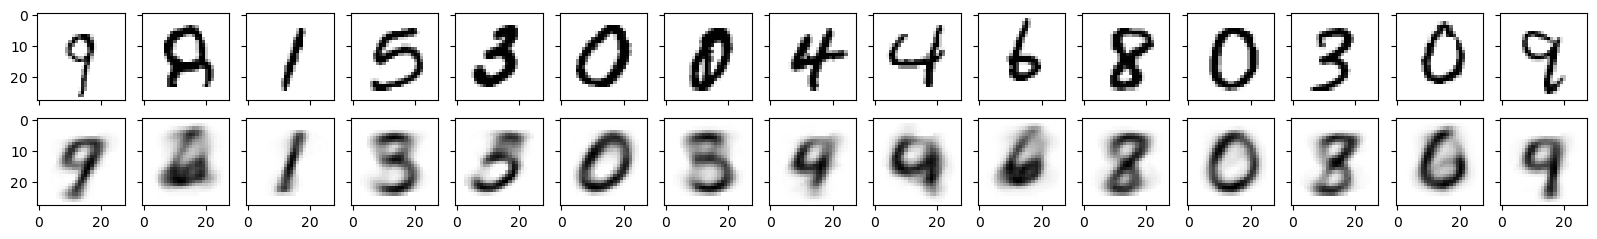

In [14]:
n_images = 15

fig, axes = plt.subplots(2, n_images, sharex=True, sharey=True, figsize=(20, 2.5))

features, _ = next(iter(train_loader))
features = features.to(device)
color_channels = features.shape[1]
image_height = features.shape[2]
image_width = features.shape[3]

with torch.no_grad():
    encoded, z_mean, z_log_var, decoded_images = model(features)[:n_images]
orig_images = features[:n_images]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        curr_img = img[i].detach().to(torch.device("cpu"))
        if color_channels > 1:
            curr_img = np.transpose(curr_img, (1, 2, 0))
            ax[i].imshow(curr_img)
        else:
            ax[i].imshow(curr_img.view((image_height, image_width)), cmap="binary")

In [ ]:
input_size = 28 * 28
num_digits = 10

params = {
    'encoder_layers': [128],
    'decoder_layers': [128],
    'z_dim': 10,
    'batch_size': 100,
    'epochs': 20
}

In [ ]:
class encoder(nn.Module):
    def __init__(self):
        super(encoder, self).__init__()

        self.linear_sigmoid = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.Sigmoid(),
            nn.Linear(128, params['z_dim'])
        )

    def forward(self, x):
        mu = self.linear_sigmoid(x)
        var = 1e-5 + torch.exp(mu)
        return mu, var

class decoder(nn.Module):
    def __init__(self):
        super(decoder, self).__init__()
        self.linear_sigmoid = nn.Sequential(
            nn.Linear(20, 128),
            nn.Sigmoid(),
            nn.Linear(128, input_size),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        mu = self.linear_sigmoid(x)
        return mu

class digit_classifier(nn.Module):
    def __init__(self):
        super(digit_classifier, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.Sigmoid(),
            nn.Linear(128, num_digits)
        )
    
    def forward(self, x):
        logits = self.main(x)
        return logits

In [ ]:
image = next(iter(train_loader))[:5]

In [ ]:
images = image[0][:5]
images.shape

torch.Size([5, 1, 28, 28])

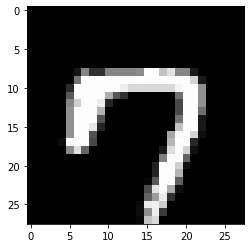

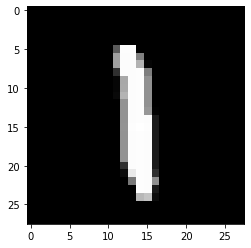

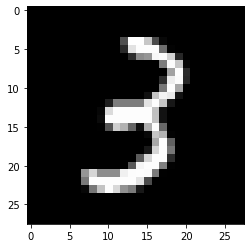

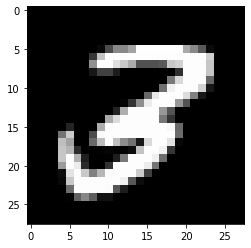

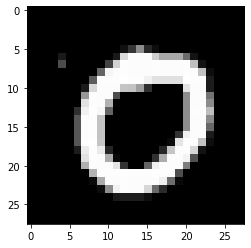

In [ ]:
for image in images:
    plt.imshow(image.numpy().reshape(28, 28))
    plt.show()

In [ ]:
E = encoder()
D = decoder()
D_cls = digit_classifier()
print(E)
print(D)
print(D_cls)

encoder(
  (linear_sigmoid): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)
decoder(
  (linear_sigmoid): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=784, bias=True)
    (3): Sigmoid()
  )
)
digit_classifier(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [ ]:
encoder_mu, encoder_var = E(images.view(-1, 28*28))

eps = torch.normal(mean=0.0, std=1.0, size=(images.shape[0], params['z_dim']))
z = encoder_mu + torch.sqrt(encoder_var) * eps

digit_logits = D_cls(images.view(-1, 28*28))
digit_prob = nn.functional.softmax(input=digit_logits)

<ipython-input-68-b00d97c5c544>:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  digit_prob = nn.functional.softmax(input=digit_logits)


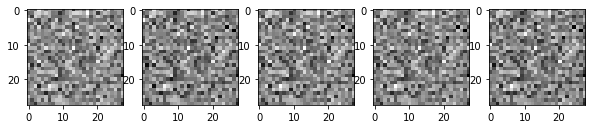

In [ ]:
decoded_images = D(torch.cat((z, digit_prob), dim=1))
plt.subplots(1, len(decoded_images), figsize=(10, 5))
for idx, image in enumerate(decoded_images):
    ax = plt.subplot(1, len(decoded_images), idx+1)
    ax.imshow(image.detach().numpy().reshape(28, 28))
plt.show()